(likelihood_ratio_process)=
```{raw} html
<div id="qe-notebook-header" align="right" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" width="250px" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>
```

# Likelihood Ratio Processes and Bayesian Learning



## Overview

This lecture describes the role that **likelihood ratio processes** play in  **Bayesian learning**.

As in {doc}`this lecture <likelihood_ratio_process>`, we'll use a simple statistical setting from {doc}`this lecture <exchangeable>`.

We'll focus on how a likelihood ratio process and a **prior** probability determine a **posterior** probability.

We'll derive a convenient recursion for today's posterior as a function of yesterday's posterior and
today's multiplicative increment to a likelihood process.

We'll also present a useful generalization of that formula that represents today's posterior in terms of an initial prior and
today's realization of the likelihood ratio process.

We'll study how, at least  in our setting, a Bayesian eventually learns the probability distribution that generates the data, an outcome that
rests on the asymptotic behavior of likelihood ratio processes studied in {doc}`this lecture <likelihood_ratio_process>`.

We'll also drill down into the psychology of our Bayesian learner and study dynamics  under his subjective beliefs.

This lecture provides technical results that underly outcomes to be studied in {doc}`this lecture <odu>`
and {doc}`this lecture <wald_friedman>` and {doc}`this lecture <navy_captain>`.

We'll begin by loading some Python modules.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
import numpy as np
from numba import vectorize, njit
from math import gamma
import pandas as pd

import seaborn as sns
colors = sns.color_palette()

@njit
def set_seed():
    np.random.seed(142857)
set_seed()

## The Setting

We begin by reviewing the setting in {doc}`this lecture <likelihood_ratio_process>`, which we adopt here too.

A nonnegative random variable $W$ has one of two probability density functions, either
$f$ or $g$.

Before the beginning of time, nature once and for all decides whether she will draw a sequence of IID draws from $f$ or from $g$.

We will sometimes let $q$ be the density that nature chose once and for all, so
that $q$ is either $f$ or $g$, permanently.

Nature knows which density it permanently draws from, but we the observers do not.

We do know both $f$ and $g$, but we don’t know which density nature
chose.

But we want to know.

To do that, we use observations.

We observe a sequence $\{w_t\}_{t=1}^T$ of $T$ IID draws
from either $f$ or $g$.

We want to use these observations to infer whether nature chose $f$ or
$g$.

A **likelihood ratio process** is a useful tool for this task.

To begin, we define the key component of a likelihood ratio process, namely, the time $t$ likelihood ratio  as the random variable

$$
\ell (w_t)=\frac{f\left(w_t\right)}{g\left(w_t\right)},\quad t\geq1.
$$

We assume that $f$ and $g$ both put positive probabilities on the
same intervals of possible realizations of the random variable $W$.

That means that under the $g$ density,  $\ell (w_t)=
\frac{f\left(w_{t}\right)}{g\left(w_{t}\right)}$
is evidently a nonnegative  random variable with mean $1$.

A **likelihood ratio process** for sequence
$\left\{ w_{t}\right\} _{t=1}^{\infty}$ is defined as

$$
L\left(w^{t}\right)=\prod_{i=1}^{t} \ell (w_i),
$$

where $w^t=\{ w_1,\dots,w_t\}$ is a history of
observations up to and including time $t$.

Sometimes for shorthand we'll write $L_t =  L(w^t)$.

Notice that the likelihood process satisfies the *recursion* or
*multiplicative decomposition*

$$
L(w^t) = \ell (w_t) L (w^{t-1}) .
$$

The likelihood ratio and its logarithm are key tools for making
inferences using a classic frequentist approach due to Neyman and
Pearson {cite}`Neyman_Pearson`.

We'll again deploy the following Python code from {doc}`this lecture <likelihood_ratio_process>` that
evaluates $f$ and $g$ as two different
beta distributions, then computes and simulates an associated likelihood
ratio process by generating a sequence $w^t$ from *some*
probability distribution, for example, a sequence of  IID draws from $g$.

In [2]:
# Parameters in the two beta distributions.
F_a, F_b = 1, 1
G_a, G_b = 3, 1.2

@vectorize
def p(x, a, b):
    r = gamma(a + b) / (gamma(a) * gamma(b))
    return r * x** (a-1) * (1 - x) ** (b-1)

# The two density functions.
f = njit(lambda x: p(x, F_a, F_b))
g = njit(lambda x: p(x, G_a, G_b))

In [3]:
@njit
def simulate(a, b, T=50, N=500):
    '''
    Generate N sets of T observations of the likelihood ratio,
    return as N x T matrix.

    '''

    l_arr = np.empty((N, T))

    for i in range(N):

        for j in range(T):
            w = np.random.beta(a, b)
            l_arr[i, j] = f(w) / g(w)

    return l_arr

We'll also use the following Python code to prepare some informative simulations

In [4]:
l_arr_g = simulate(G_a, G_b, N=50000)
l_seq_g = np.cumprod(l_arr_g, axis=1)

In [5]:
l_arr_f = simulate(F_a, F_b, N=50000)
l_seq_f = np.cumprod(l_arr_f, axis=1)

## Likelihood Ratio Process and Bayes’ Law

Let $\pi_t$ be a Bayesian posterior defined as

$$
\pi_t = {\rm Prob}(q=f|w^t)
$$

The likelihood ratio process is a principal actor in the formula that governs the evolution
of the posterior probability $\pi_t$, an instance of **Bayes' Law**.

Bayes’ law implies that $\{\pi_t\}$ obeys the recursion

```{math}
:label: eq_recur1

\pi_t=\frac{\pi_{t-1} l_t(w_t)}{\pi_{t-1} l_t(w_t)+1-\pi_{t-1}}
```

with $\pi_{0}$ being a Bayesian prior probability that $q = f$,
i.e., a personal or subjective belief about $q$ based on our having seen no data.

Below we define a Python function that updates belief $\pi$ using
likelihood ratio $\ell$ according to  recursion {eq}`eq_recur1`

In [6]:
@njit
def update(π, l):
    "Update π using likelihood l"

    # Update belief
    π = π * l / (π * l + 1 - π)

    return π

Formula {eq}`eq_recur1` can be generalized  by iterating on it and thereby deriving an
expression for  the time $t$ posterior $\pi_{t+1}$ as a function
of the time $0$ prior $\pi_0$ and the likelihood ratio process
$L(w^{t+1})$ at time $t$.

To begin, notice that the updating rule

$$
\pi_{t+1}
=\frac{\pi_{t}\ell \left(w_{t+1}\right)}
{\pi_{t}\ell \left(w_{t+1}\right)+\left(1-\pi_{t}\right)}
$$

implies

$$
\begin{aligned}
\frac{1}{\pi_{t+1}}
    &=\frac{\pi_{t}\ell \left(w_{t+1}\right)
        +\left(1-\pi_{t}\right)}{\pi_{t}\ell \left(w_{t+1}\right)} \\
    &=1-\frac{1}{\ell \left(w_{t+1}\right)}
        +\frac{1}{\ell \left(w_{t+1}\right)}\frac{1}{\pi_{t}}.
\end{aligned}
$$

$$
\Rightarrow
\frac{1}{\pi_{t+1}}-1
=\frac{1}{\ell \left(w_{t+1}\right)}\left(\frac{1}{\pi_{t}}-1\right).
$$

Therefore

$$
\begin{aligned}
    \frac{1}{\pi_{t+1}}-1
    =\frac{1}{\prod_{i=1}^{t+1}\ell \left(w_{i}\right)}
        \left(\frac{1}{\pi_{0}}-1\right)
    =\frac{1}{L\left(w^{t+1}\right)}\left(\frac{1}{\pi_{0}}-1\right).
\end{aligned}
$$

Since $\pi_{0}\in\left(0,1\right)$ and
$L\left(w^{t+1}\right)>0$, we can verify that
$\pi_{t+1}\in\left(0,1\right)$.

After rearranging the preceding equation, we can express $\pi_{t+1}$ as a
function of  $L\left(w^{t+1}\right)$, the  likelihood ratio process at $t+1$,
and the initial prior $\pi_{0}$

```{math}
:label: eq_Bayeslaw103

\pi_{t+1}=\frac{\pi_{0}L\left(w^{t+1}\right)}{\pi_{0}L\left(w^{t+1}\right)+1-\pi_{0}} .
```

Formula {eq}`eq_Bayeslaw103` generalizes formula {eq}`eq_recur1`.

Formula {eq}`eq_Bayeslaw103`  can be regarded as a one step  revision of prior probability $\pi_0$ after seeing
the batch of data $\left\{ w_{i}\right\} _{i=1}^{t+1}$.

Formula {eq}`eq_Bayeslaw103` shows the key role that the likelihood ratio process  $L\left(w^{t+1}\right)$ plays in determining
the posterior probability $\pi_{t+1}$.

Formula {eq}`eq_Bayeslaw103` is the foundation for the insight that, because of how the likelihood ratio process behaves
as $t \rightarrow + \infty$, the likelihood ratio process dominates the initial prior $\pi_0$ in determining the
limiting behavior of $\pi_t$.

To illustrate this insight, below we will plot  graphs showing **one** simulated
path of the  likelihood ratio process $L_t$ along with two paths of
$\pi_t$ that are associated with the *same* realization of the likelihood ratio process but *different* initial prior probabilities $\pi_{0}$.

First, we tell Python two values of $\pi_0$.

In [7]:
π1, π2 = 0.2, 0.8

Next we generate paths of the likelihood ratio process $L_t$ and the posterior $\pi_t$ for a
history of IID draws from density $f$.

In [8]:
T = l_arr_f.shape[1]
π_seq_f = np.empty((2, T+1))
π_seq_f[:, 0] = π1, π2

for t in range(T):
    for i in range(2):
        π_seq_f[i, t+1] = update(π_seq_f[i, t], l_arr_f[0, t])

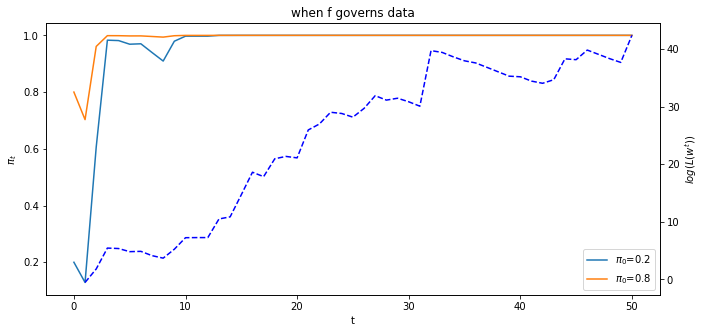

In [9]:
fig, ax1 = plt.subplots()

for i in range(2):
    ax1.plot(range(T+1), π_seq_f[i, :], label=f"$\pi_0$={π_seq_f[i, 0]}")

ax1.set_ylabel("$\pi_t$")
ax1.set_xlabel("t")
ax1.legend()
ax1.set_title("when f governs data")

ax2 = ax1.twinx()
ax2.plot(range(1, T+1), np.log(l_seq_f[0, :]), '--', color='b')
ax2.set_ylabel("$log(L(w^{t}))$")

plt.show()

The dotted line in the graph above records the logarithm of the  likelihood ratio process $\log L(w^t)$.

Please note that there are two different scales on the $y$ axis.

Now let's study what happens when the history consists of IID draws from density $g$

In [10]:
T = l_arr_g.shape[1]
π_seq_g = np.empty((2, T+1))
π_seq_g[:, 0] = π1, π2

for t in range(T):
    for i in range(2):
        π_seq_g[i, t+1] = update(π_seq_g[i, t], l_arr_g[0, t])

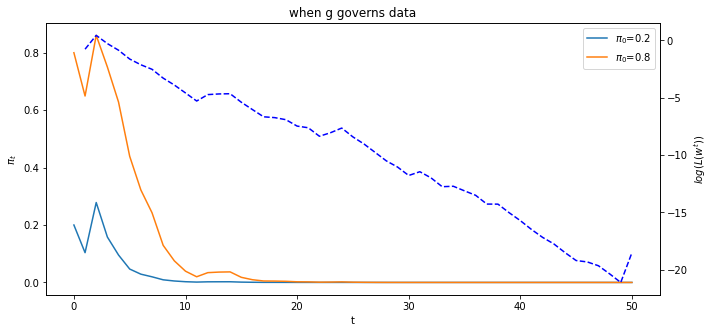

In [11]:
fig, ax1 = plt.subplots()

for i in range(2):
    ax1.plot(range(T+1), π_seq_g[i, :], label=f"$\pi_0$={π_seq_g[i, 0]}")

ax1.set_ylabel("$\pi_t$")
ax1.set_xlabel("t")
ax1.legend()
ax1.set_title("when g governs data")

ax2 = ax1.twinx()
ax2.plot(range(1, T+1), np.log(l_seq_g[0, :]), '--', color='b')
ax2.set_ylabel("$log(L(w^{t}))$")

plt.show()

Below we offer Python code that verifies that nature chose permanently to draw from density $f$.

In [12]:
π_seq = np.empty((2, T+1))
π_seq[:, 0] = π1, π2

for i in range(2):
    πL = π_seq[i, 0] * l_seq_f[0, :]
    π_seq[i, 1:] = πL / (πL + 1 - π_seq[i, 0])

In [13]:
np.abs(π_seq - π_seq_f).max() < 1e-10

True

We thus conclude that  the likelihood ratio process is a key ingredient of the formula {eq}`eq_Bayeslaw103` for
a Bayesian's posteior probabilty that nature has drawn history $w^t$ as repeated draws from density
$g$.




## Behavior of  posterior probability $\{\pi_t\}$  under the subjective probability distribution


We'll end this lecture by briefly studying what our Baysian learner expects to learn under the 
subjective beliefs $\pi_t$ cranked out by Bayes' law.  

This will provide us with some perspective  on our application of  Bayes's law as a theory of learning.

As we shall see, at each time $t$, the Bayesian learner knows that he will be surprised.

But he expects that new information will not lead him  to change his beliefs.

And it won't on average under his subjective beliefs.  

We'll continue with our setting in which a McCall worker  knows that successive
draws of his wage are drawn from either $F$ or $G$, but  does not know which of these two  distributions
nature has drawn once-and-for-all before time $0$.

We'll review and reiterate and rearrange some formulas that we have encountered above and in associated lectures. 

The worker's initial beliefs induce a joint probability distribution
 over a potentially infinite sequence of draws $w_0, w_1, \ldots $. 
 
Bayes' law is simply an application of  laws of
 probability to compute the conditional distribution of the $t$th draw $w_t$ conditional on $[w_0, \ldots, w_{t-1}]$. 
 
After our worker puts a subjective probability $\pi_{-1}$ on nature having selected distribution $F$, we have in effect assumes from the start that the   decision maker **knows** the joint distribution  for the process $\{w_t\}_{t=0}$.  

We assume that the workers also knows the laws of probability theory.

A respectable view is that Bayes' law is less a theory of learning than a statement  about the consequences of information inflows for a decision maker who thinks he knows the truth (i.e., a joint probability distribution) from the beginning.


### Mechanical details again

At time $0$ **before** drawing a wage offer, the worker attaches probability $\pi_{-1} \in (0,1)$ to the distribution being $F$.  
 
Before drawing a wage at time $0$, the  worker thus believes that the density of $w_0$
is 

$$
h(w_0;\pi_{-1}) = \pi_{-1} f(w_0) + (1-\pi_{-1}) g(w_0).
$$

Let $a \in \{ f, g\} $ be an index that indicates whether  nature chose permanently to draw from distribution $f$ or from distribution $g$. 

After drawing $w_0$, the worker uses Bayes' law to deduce that
the posterior  probability $\pi_0 = {\rm Prob}{a = f | w_0} $
that the density is $f(w)$ is
 
$$
\pi_0 = { \pi_{-1} f(w_0) \over \pi_{-1} f(w_0) + (1-\pi_{-1}) g(w_0)} .
$$


More generally,  after making the $t$th draw and having   observed   $w_t, w_{t-1}, \ldots, w_0$, the worker believes that
the probability that $w_{t+1}$ is  being drawn from  distribution  $F$ is

$$ 
\pi_t = \pi_t(w_t | \pi_{t-1}) \equiv { \pi_{t-1} f(w_t)/g(w_t) \over \pi_{t-1} f(w_t)/g(w_t) + (1-\pi_{t-1})} 
$$ (eq:like44)


or


$$
\pi_t=\frac{\pi_{t-1} l_t(w_t)}{\pi_{t-1} l_t(w_t)+1-\pi_{t-1}} 
$$


and that the density of $w_{t+1}$ conditional on $w_t, w_{t-1}, \ldots, w_0$ is

$$
h(w_{t+1};\pi_{t}) = \pi_{t} f(w_{t+1}) + (1-\pi_{t}) g(w_{t+1}) . 
$$

Notice that

$$ 
\begin{aligned}
E(\pi_t | \pi_{t-1}) & = \int \Bigl[  { \pi_{t-1} f(w) \over \pi_{t-1} f(w) + (1-\pi_{t-1})g(w)  } \Bigr]
 \Bigl[ \pi_{t-1} f(w) + (1-\pi_{t-1})g(w) \Bigr]  d w \cr
& = \pi_{t-1} \int  f(w) dw  \cr
              & = \pi_{t-1}, \cr
\end{aligned}
$$
              
so that the process $\pi_t$ is a **martingale**.

Indeed, it is a **bounded martingale** because each $\pi_t$, being a probability,
is between $0$ and $1$.


In the first line in the above string of equalities, the term in the first set of brackets
is just $\pi_t$ as a function of $w_{t}$, while the term in the second set of brackets is the density of $w_{t}$ conditional
on $w_{t-1}, \ldots , w_0$ or equivalently conditional on the *sufficient statistic* $\pi_{t-1}$ for $w_{t-1}, \ldots , w_0$. 

Notice that here we are computing $E(\pi_t | \pi_{t-1})$ under the **subjective** density described in the second
term in brackets.

Because $\{\pi_t\}$ is a bounded martingale sequence, it follows from the **martingale convergence theorem** that $\pi_t$ converges almost surely to a random variable in $[0,1]$.  

Practically, this means that  probability one is  attached to   sample paths
 $\{\pi_t\}_{t=0}^\infty$ that  converge.  
 
According to the theorem,  it  different sample  paths  can converge to different limiting values.

Thus, let $\{\pi_t(\omega)\}_{t=0}^\infty$ denote a particular sample path indexed by a particular $\omega
\in \Omega$.  

We can think of nature as drawing an $\omega \in \Omega$ from a probability distribution
${\textrm{Prob}} \Omega$ and then generating a single realization (or _simulation_) $\{\pi_t(\omega)\}_{t=0}^\infty$ of the process.

The limit points of  $\{\pi_t(\omega)\}_{t=0}^\infty$ as $t \rightarrow +\infty$ are realizations of a random variable that  is swept out as we sample $\omega$ from $\Omega$ and construct repeated draws of $\{\pi_t(\omega)\}_{t=0}^\infty$.  
 
 
By staring at law of motion {eq}`eq_recur1` or {eq}`eq:like44` , we can figure out some things about the probability distribution of the limit points



$$
\pi_\infty(\omega) = \lim_{t \rightarrow + \infty} \pi_t(\omega).
$$




Evidently, since the likelihood ratio $\ell(w_t) $ differs from $1$ when $f \neq g$,
as we have assumed, the only possible fixed points of {eq}`eq:like44` are 

$$ 
\pi_\infty(\omega) =1 
$$


and 

$$ 
\pi_\infty(\omega) =0 
$$


Thus, for some realizations, $\lim_{\rightarrow + \infty} \pi_t(\omega) =1$
while for other realizations,  $\lim_{\rightarrow + \infty} \pi_t(\omega) =0$.

Now let's remember that $\{\pi_t\}_{t=0}^\infty$ is a martingale and apply the law of iterated expectations.


The law of iterated expectations implies 

$$ 
E_t \pi_{t+j}  = \pi_t
$$

and in particular

$$
E_{-1} \pi_{t+j} = \pi_{-1}. 
$$

Applying the above formula to $\pi_\infty$, we obtain

$$
E_{-1} \pi_\infty(\omega) = \pi_{-1}
$$

where the mathematical expectation $E_{-1}$ here is taken with respect to the probability
measure ${\textrm{Prob}(\Omega)}$.

Since the only two values that $\pi_\infty(\omega)$ can take are $1$ and $0$, we know that for some $\lambda \in [0,1]$

$$
{\textrm{Prob}}\Bigl(\pi_\infty(\omega) = 1\Bigr) = \lambda, \quad {\textrm{Prob}}\Bigl(\pi_\infty(\omega) = 0\Bigr) = 1- \lambda
$$

and consequently that

$$
E_{-1} \pi_\infty(\omega) = \lambda \cdot 1 + (1-\lambda) \cdot 0 = \lambda 
$$ 


Combining this equation with equation (20), we deduce that 
the probability that ${\textrm{Prob}(\Omega)}$ attaches to
$\pi_\infty(\omega)$ being $1$ must be $\pi_{-1}$.


Thus, under the worker's subjective distribution, $\pi_{-1}$ of the sample paths 
of $\{\pi_t\}$ will converge pointwise to $1$ and $1 - \pi_{-1}$ of the sample paths will 
converge pointwise to $0$.



### Some simulations

Let's watch the martingale convergence theorem at work in some simulations of our learning model under the worker's subjective distribution.

Let us simulate $\left\{ \pi_{t}\right\} _{t=0}^{T}$, $\left\{ w_{t}\right\} _{t=0}^{T}$ paths where for each $t\geq0$, $w_t$ is drawn from the subjective distribution

$$
\pi_{t-1}f\left(w_{t}\right)+\left(1-\pi_{t-1}\right)g\left(w_{t}\right)
$$

We'll plot a large sample of paths.

In [14]:
@njit
def martingale_simulate(π0, N=5000, T=200):
    
    π_path = np.empty((N,T+1))
    w_path = np.empty((N,T))
    π_path[:,0] = π0

    for n in range(N):
        π = π0
        for t in range(T):
            # draw w
            if np.random.rand() <= π:
                w = np.random.beta(F_a, F_b)
            else:
                w = np.random.beta(G_a, G_b)
            π = π*f(w)/g(w)/(π*f(w)/g(w) + 1 - π)
            π_path[n,t+1] = π
            w_path[n,t] = w
        
    return π_path, w_path

def fraction_0_1(π0, N, T, decimals):
    
    π_path, w_path = martingale_simulate(π0, N=N, T=T)
    values, counts = np.unique(np.round(π_path[:,-1], decimals=decimals), return_counts=True)
    return values, counts

def create_table(π0s, N=10000, T=500, decimals=2):
 
    outcomes = []
    for π0 in π0s:
        values, counts = fraction_0_1(π0, N=N, T=T, decimals=decimals)
        freq = counts/N
        outcomes.append(dict(zip(values, freq)))
    table = pd.DataFrame(outcomes).sort_index(axis=1).fillna(0)
    table.index = π0s
    return table



# simulate
T = 200
π0 = .5

π_path, w_path = martingale_simulate(π0=π0, T=T, N=10000)

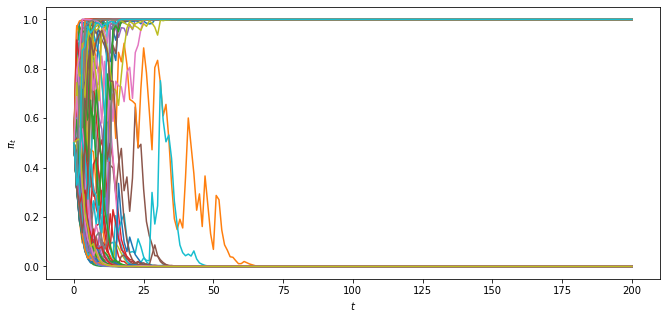

In [15]:
fig, ax = plt.subplots()
for i in range(100):
    ax.plot(range(T+1), π_path[i, :])

ax.set_xlabel('$t$')
ax.set_ylabel('$\pi_t$')
plt.show()

Now let's plot two paths of pairs of $\{\pi_t, w_t\}$ sequences, one in which $\pi_t \rightarrow 1$,
another in which $\pi_t \rightarrow 0$.

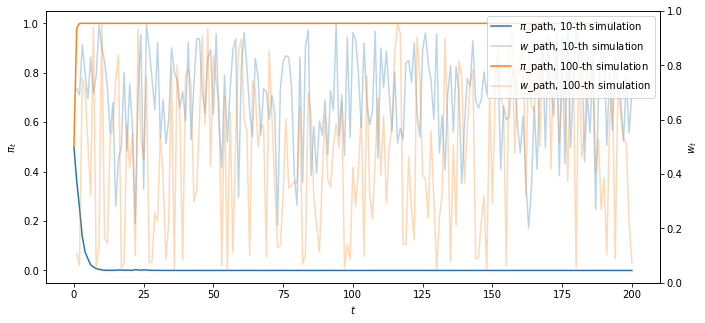

In [16]:
fig, ax = plt.subplots()
for i, j in enumerate([10, 100]):
    ax.plot(range(T+1), π_path[j,:], color=colors[i], label=f'$\pi$_path, {j}-th simulation')
    ax.plot(range(1,T+1), w_path[j,:], color=colors[i], label=f'$w$_path, {j}-th simulation', alpha=0.3)
    
ax.legend(loc='upper right')
ax.set_xlabel('$t$')
ax.set_ylabel('$\pi_t$')
ax2 = ax.twinx()
ax2.set_ylabel("$w_t$")
plt.show()

Let's plot histograms of $\pi_t$ for various values of $t$.

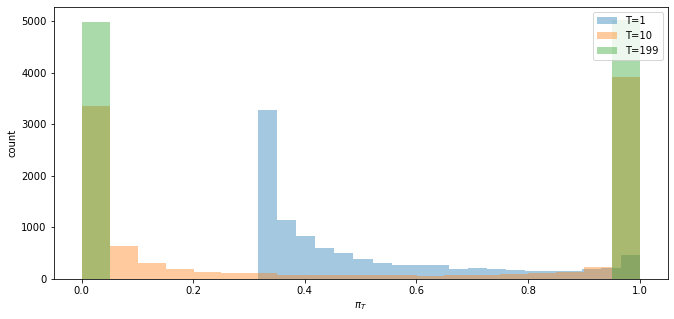

In [17]:
fig, ax = plt.subplots()
for t in [1, 10, T-1]:
    ax.hist(π_path[:,t], bins=20, alpha=0.4, label=f'T={t}')
    
ax.set_ylabel('count')
ax.set_xlabel('$\pi_T$')
ax.legend(loc='upper right')
plt.show()

The above graphs display how the distribution of $\pi_t$ across realizations are moving toward 
limit points that we described above and that put all probability either on $0$ or on $1$. 



Now let's use our Python code to generate a table that checks out our earlier claims about the 
probability distribution of the pointwise limits $\pi_{\infty}(\omega)$.

We'll use our simulations to generate a histogram of this distribution.

In the following table, the left column in bold face reports an assumed value of $\pi_{-1}$. 

The second column reports the fraction of $N = 10000$ simulations for which $\pi_{t}$  had converged to $0$  at the terminal date $T=500$ for each simulation.

The third column reports the fraction of $N = 10000$ simulations for which $\pi_{t}$  had converged to $1$ as the terminal date $T=500$ for each simulation.

In [18]:
# create table
table = create_table(list(np.linspace(0,1,11)), N=10000, T=500)
table

,0.0,1.0
0.0,1.0000,0.0000
0.1,0.8983,0.1017
0.2,0.7998,0.2002
0.3,0.6953,0.3047
0.4,0.6001,0.3999
0.5,0.5059,0.4941
0.6,0.3987,0.6013
0.7,0.3068,0.6932
0.8,0.2021,0.7979
0.9,0.0991,0.9009


The fraction of simulations for which $\pi_{t}$  had converged to $1$ is indeed always  close  to $\pi_{-1}$, as anticipated.









## Sequels

This lecture has been devoted to building some useful infrastructure that will help us understand inferences that are the foundations of
results described  in {doc}`this lecture <odu>` and {doc}`this lecture <wald_friedman>` and {doc}`this lecture <navy_captain>`.